In [1]:
import sys  
sys.path.insert(0, 'C:\\Users\\espebh\\Documents\\Thesis\\code')
import os
import numpy as np
import torch
import torchvision
import json
from PIL import Image
import random
import pickle
import matplotlib.pyplot as plt
from helpers import m
from helpers.dataset_evaluation import print_class_distribution, size_smallest_class
import cv2

In [2]:
data_in_path = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\semiautomatically generated data\\test data\\balanced_data'
data_out_path = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\semiautomatically generated data\\test data\dot_data_balanced'

In [3]:
class salmonToraxDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.transforms = torchvision.transforms.ToTensor()
        self.imgs = list(sorted(os.listdir(os.path.join(path, 'images'))))
        self.targets = list(sorted(os.listdir(os.path.join(path, 'labels'))))
        self.path = path
        
    def __getitem__(self, idx):
        
        with open(os.path.join(self.path, 'labels', self.targets[idx])) as f:
            label = json.load(f)
        img = Image.open(os.path.join(self.path, 'images', self.imgs[idx]))

        img_tensor = torchvision.transforms.functional.pil_to_tensor(img)
        img_tensor = torch.div(img_tensor, 255)
        img_tensor = img_tensor.to(m.DEVICE)
        return img_tensor, label

    def __len__(self):
        return len(self.imgs)

In [4]:
in_dataset = salmonToraxDataset(data_in_path)
data_loader_in = torch.utils.data.DataLoader(in_dataset, batch_size=32, shuffle=True)
print_class_distribution(data_loader_in)

Class:  0  has  0 datapoints
Class:  1  has  105 datapoints
Class:  2  has  105 datapoints
Class:  3  has  105 datapoints
Class:  4  has  105 datapoints
Class:  5  has  105 datapoints
Class:  6  has  105 datapoints
Class:  7  has  105 datapoints
Class:  8  has  105 datapoints
Class:  9  has  105 datapoints
Class:  10  has  105 datapoints
Class:  11  has  105 datapoints
Class:  12  has  105 datapoints
Class:  13  has  0 datapoints
Class:  14  has  0 datapoints
Class:  15  has  105 datapoints
Class:  16  has  105 datapoints


In [5]:
# from skimage import exposure
# ex_img_name = '1t_t9 4019.1'
# ex_img_path = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\semiautomatically generated data\\labelled data\\data\\images'

# ref = cv2.imread(os.path.join(ex_img_path, ex_img_name + '.jpeg'))


# # Create albumentations pipeline
# import albumentations as alb
# from albumentations import Blur 


# augmentor = alb.Compose([alb.augmentations.domain_adaptation.HistogramMatching(os.path.join(ex_img_path, ex_img_name), {x:x})
#                         ])

In [6]:
def generate_dot_masks_from_gray_images(images):
    dot_masks = []
    for image in images:
        thresh = cv2.adaptiveThreshold(np.multiply(image, 255).astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,9,21)
        threshold_img = np.array(image<thresh).astype(np.uint8)
        dot_masks.append(threshold_img)
    return dot_masks

In [7]:
def data_loader_to_dot_network_in(images, targets):
    net_in_imgs = []
    net_in_targets = []
    for i in range(len(images)):
        img = images[i].detach().cpu().numpy().astype(np.float32).transpose(1,2,0).copy()
        target = targets[i].detach().cpu().numpy().astype(np.uint8)
        img_gray = cv2.cvtColor(img.astype(np.float32).copy(), cv2.COLOR_BGR2GRAY).astype(float)
        img_mask = generate_dot_masks_from_gray_images([img_gray])[0]
        img_laplacian = cv2.normalize(cv2.Laplacian(img_gray.copy(),cv2.CV_64F).astype(float), None, 0, 1, cv2.NORM_MINMAX)
        net_in_imgs.append(np.dstack([img_gray, img_mask, img_laplacian]))
        net_in_targets.append(target)
    return net_in_imgs, net_in_targets


In [8]:
def cv2_to_dot_network_in(image):
    net_in_imgs = []
    net_in_targets = []
    img_gray = cv2.normalize(cv2.cvtColor(image.astype(np.float32).copy(), cv2.COLOR_BGR2GRAY).astype(float), None, 0, 1, cv2.NORM_MINMAX)
    img_mask = generate_dot_masks_from_gray_images([img_gray])[0]
    img_laplacian = cv2.normalize(cv2.Laplacian(img_gray.copy(),cv2.CV_64F).astype(float), None, 0, 1, cv2.NORM_MINMAX)
    return np.dstack([img_gray, img_mask, img_laplacian])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


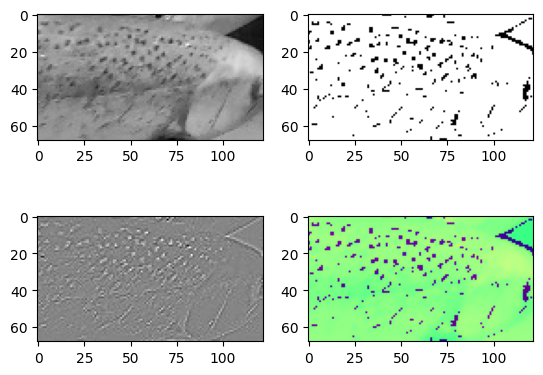

In [9]:
#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2, 2))

images, targets = next(iter(data_loader_in))
net_in_imgs, net_in_targtes = data_loader_to_dot_network_in(images, targets)

nr = 0
fig, ax = plt.subplots(2, 2)
ax[0][0].imshow(net_in_imgs[nr][:,:,0], cmap = 'gray')
ax[0][1].imshow(net_in_imgs[nr][:,:,1], cmap = 'gray')
ax[1][0].imshow(net_in_imgs[nr][:,:,2], cmap = 'gray')
ax[1][1].imshow(net_in_imgs[nr])


In [10]:
test = True

# Create dot mask dtaset
for image in os.listdir(os.path.join(data_in_path, 'images')):
    # Read in image
    img = cv2.imread(os.path.join(data_in_path, 'images', image))
    img_in = np.multiply(cv2_to_dot_network_in(img), 255).astype(np.uint8)

    # Read in label
    if not test:
        label_path = os.path.join(data_in_path,'labels', image.split(".")[0] + '.' + image.split(".")[1] + '.json')
    if test:
        label_path = os.path.join(data_in_path,'labels', image.split(".")[0] + '.json')
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            label = json.load(f)
    try: 
        cv2.imwrite(os.path.join(data_out_path, 'images_gray', image), img_in[:,:,0]) # Save image
        cv2.imwrite(os.path.join(data_out_path, 'images_mask', image), img_in[:,:,1]) # Save image
        cv2.imwrite(os.path.join(data_out_path, 'images_lap', image), img_in[:,:,2]) # Save image
        with open(os.path.join(data_out_path, 'labels', image + '.json'), 'w') as f: # Save label
            json.dump(label, f)
    except Exception as e:
        print(e)

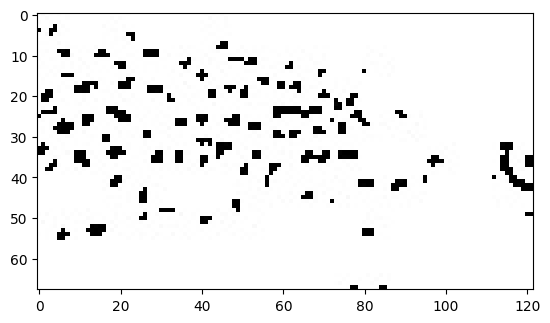

In [11]:
out = cv2.imread(os.path.join(data_out_path, 'images_mask', '1' + '.jpeg'))
plt.imshow(out[:,:,0], cmap = 'gray')